In [1]:
import os
import sys
import time
import glob
import numpy as np
import pandas as pd
import scipy.ndimage as nd
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf
from numpy import genfromtxt
from scipy import stats
from sklearn import linear_model
from sklearn.cluster import KMeans
from ph_scan import *

In [2]:
# -- initialize seed
np.random.seed(234)

In [3]:
fname = 'Delivery/057773250120_01/057773250120_01_P004_MUL/17SEP29170130-M2AS-057773250120_01_P004.TIF'
scan = PhScan(fname)

reading Delivery/057773250120_01/057773250120_01_P004_MUL/17SEP29170130-M2AS-057773250120_01_P004.TIF...
extracting to array...  (extracted in 0.188667058945s)
rescaling...


In [4]:
img0 = scan.img.transpose(1, 2, 0)
img0.shape

(1412, 2263, 4)

In [5]:
ndvi = scan.ndvi

In [6]:
ndvi.shape

(1412, 2263)

In [7]:
# only include pixels have ndvi larger than 0.2
mask = ndvi <= 0.2
mask = mask*1
mask

array([[1, 1, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       [0, 0, 0, ..., 1, 1, 1],
       ..., 
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 1, 1, 1]])

In [8]:
b = np.repeat(mask[:, :, np.newaxis], 4, axis=2)

In [9]:
array_masked = np.ma.array(img0, mask=b, fill_value=0)
img = array_masked.filled()
img.shape

(1412, 2263, 4)

In [10]:
# -- put this into a shape for clustering
nrow = img.shape[0]
ncol = img.shape[1]
nwav = img.shape[2]
npix = nrow * ncol

In [11]:
data = np.zeros((nrow, ncol, nwav * 25), dtype=img.dtype)

In [12]:
for ii in range(2, nrow - 2):
    for jj in range(2, ncol - 2):
        data[ii, jj] = img[ii - 2: ii + 3, jj - 2: jj + 3] \
            .transpose(2, 0, 1).flatten()

In [14]:
data = data.transpose(2, 0, 1).reshape(data.shape[2], npix).T

In [16]:
# -- cluster a 5% subset
km = KMeans(20, n_jobs=10)
norm = data - data.mean(1, keepdims=True)
norm /= norm.std(1, keepdims=True) + (norm.std(1, keepdims=True) == 0)

In [18]:
# np.random.seed(234970)
ind_nz = np.where(norm.any(axis=1))[0]
# ind_nz = np.where(scan.ndvi.any(axis=1))[0]

In [19]:
ind_nz

array([   4528,    4529,    4530, ..., 3190220, 3190221, 3190222])

In [20]:
ind = np.random.choice(ind_nz, int(0.05 * npix))

In [21]:
km.fit(norm[ind])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=10, n_jobs=10, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [22]:
labs = np.ones((npix), dtype=float) * 20

In [23]:
# -- predict on whole data set
labs[ind_nz] = km.predict(norm[ind_nz])
labs_img = labs.reshape(nrow, ncol)

In [24]:
labs_img[labs_img == 20.0] = np.NaN

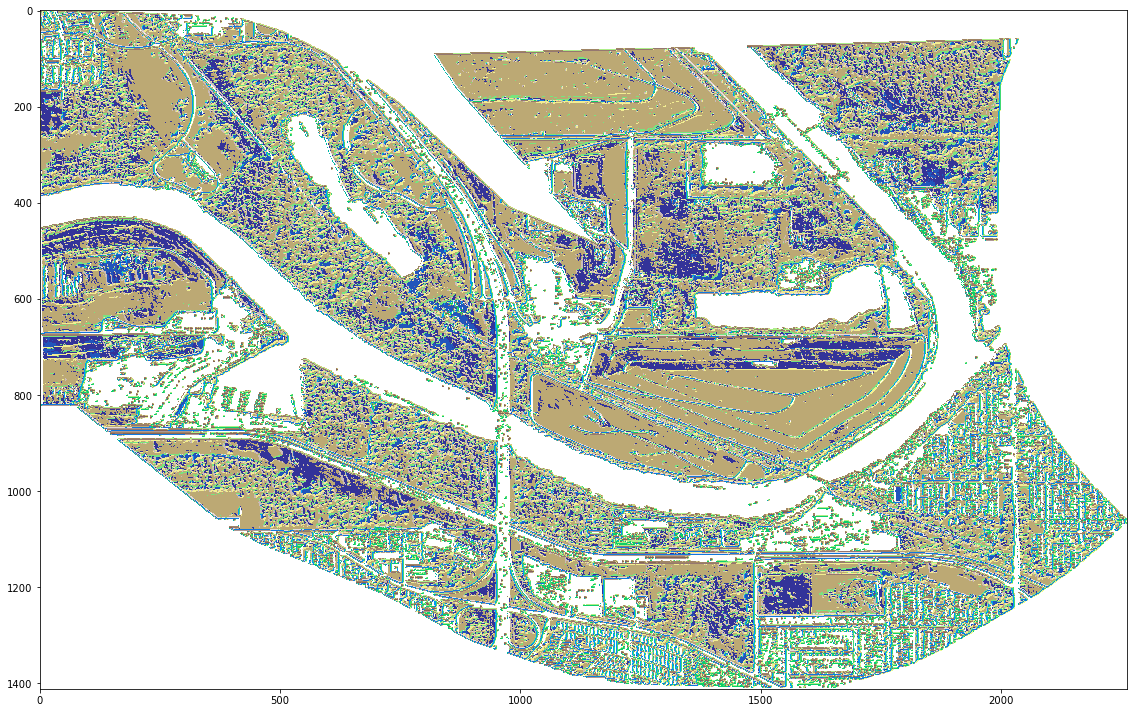

In [25]:
xsize = 20.
ysize = xsize * float(nrow) / float(ncol)
plt.figure(figsize=[xsize, ysize])
fn = fname.split(".")[0]
fn = fn.replace('/', '.')
plt.imshow(labs_img, cmap='terrain')
plt.show
plt.savefig("cluster_ndvi_0.2/"+fn+".png")